# What will happen in the 2026 South African Local Elections?


### Author: Luka Vukosi Nyathi
### Institution: University of Johannesburg
### Purpose: Predict the top 3 Political Organizations performance in the next Local Elections

# Imported Libraries

In [547]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from textblob import TextBlob
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import warnings


In [302]:
!pip install textblob

## Loading Past Local Election Results (Datasets)

##### We are going to work with 5 different datasets of each of the past local elections. this aims to give of indepth knowledge of the performance of each political party in the local elections. 

In [14]:
dataset2006 = pd.read_excel('elections 2006.xlsx')
dataset2006.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2006,ANC,Limpopo,25.0,856.0,83.59
1,2006,ANC,Gauteng,10.0,532.0,61.85
2,2006,ANC,Mpumalanga,18.0,578.0,79.84
3,2006,ANC,Free State,20.0,462.0,76.23
4,2006,ANC,North West,21.0,554.0,75.88


In [156]:
dataset2011 = pd.read_excel('elections2011.xlsx')
dataset2011.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2011,ANC,Limpopo,25,882,80.59
1,2011,ANC,Gauteng,9,622,59.66
2,2011,ANC,Mpumalanga,18,625,78.03
3,2011,ANC,Free State,20,448,71.02
4,2011,ANC,North West,19,571,74.03


In [158]:
dataset2016 = pd.read_excel('elections 2016.xlsx')
dataset2016.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2016,ANC,Limpopo,20,784,68.75
1,2016,ANC,Gauteng,4,499,45.84
2,2016,ANC,Mpumalanga,17,561,70.74
3,2016,ANC,Free State,18,385,61.53
4,2016,ANC,North West,17,494,59.36


In [160]:
dataset2021 = pd.read_excel('elections 2021.xlsx')
dataset2021.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2021,ANC,Limpopo,20,787,68.27
1,2021,ANC,Gauteng,0,399,36.06
2,2021,ANC,Mpumalanga,14,475,59.30
3,2021,ANC,Free State,15,328,50.61
4,2021,ANC,North West,15,456,55.43


## Data Cleaning

In [43]:

missing_data_2009 = pd.DataFrame({
    'column': dataset2006.columns,
    'missing_values': dataset2006.isnull().sum(),
    'data_type': dataset2006.dtypes
})

missing_data_2011 = pd.DataFrame({
    'column': dataset2011.columns,
    'missing_values': dataset2011.isnull().sum(),
    'data_type': dataset2011.dtypes
})

missing_data_2016 = pd.DataFrame({
    'column': dataset2016.columns,
    'missing_values': dataset2016.isnull().sum(),
    'data_type': dataset2016.dtypes
})

missing_data_2021 = pd.DataFrame({
    'column': dataset2021.columns,
    'missing_values': dataset2021.isnull().sum(),
    'data_type': dataset2021.dtypes
})

display(missing_data_2009, missing_data_2011, missing_data_2016, missing_data_2021)

,column,missing_values,data_type
Year,Year,0,int64
Party Name,Party Name,0,object
Province,Province,0,object
Councils,Councils,9,float64
Seats,Seats,9,float64
Support (%),Support (%),9,float64


,column,missing_values,data_type
Year,Year,0,int64
Party Name,Party Name,0,object
Province,Province,0,object
Councils,Councils,0,int64
Seats,Seats,0,int64
Support (%),Support (%),0,float64


,column,missing_values,data_type
Year,Year,0,int64
Party Name,Party Name,0,object
Province,Province,0,object
Councils,Councils,0,int64
Seats,Seats,0,int64
Support (%),Support (%),0,float64


,column,missing_values,data_type
Year,Year,0,int64
Party Name,Party Name,0,object
Province,Province,0,object
Councils,Councils,0,int64
Seats,Seats,0,int64
Support (%),Support (%),0,float64


#### Dropping the missing values found in 2006 Dataset

In [113]:
missing_data_2006 = dataset2006.dropna()
missing_data_2006

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2006,ANC,Limpopo,25.0,856.0,83.59
1,2006,ANC,Gauteng,10.0,532.0,61.85
2,2006,ANC,Mpumalanga,18.0,578.0,79.84
3,2006,ANC,Free State,20.0,462.0,76.23
4,2006,ANC,North West,21.0,554.0,75.88
5,2006,ANC,Eastern Cape,37.0,1060.0,80.41
6,2006,ANC,Northern Cape,27.0,234.0,69.36
7,2006,ANC,KZN,19.0,686.0,47.56
8,2006,ANC,Western Cape,2.0,289.0,39.55
9,2006,DA,Limpopo,0.0,59.0,5.59


#### The displayed dataset has removed all the missing values in the 2006 dataset. It can shows the Two parties from index 0 - 17 meaning 18 complete rows of data.

## Descriptive Statistics

**2006 Descriptive statistics**

In [88]:
dataset2006["Councils"] = pd.to_numeric(dataset2006["Councils"])
dataset2006["Seats"] = pd.to_numeric(dataset2006["Seats"])
dataset2006["Support (%)"] = pd.to_numeric(dataset2006["Support (%)"])

In [74]:
party_stats = dataset2006.groupby("Party Name").agg({
    "Councils": ["mean", "median", "std", "min", "max"],
    "Seats": ["mean", "median", "std", "min", "max"],
    "Support (%)": ["mean", "median", "std", "min", "max"]
})

counsil_stats = party_stats["Councils"]
Seats_stats = party_stats["Seats"]
support_stats = party_stats["Support (%)"]

counsil_stats
Seats_stats
support_stats

,mean,median,std,min,max
Party Name,,,,,
ANC,68.252222,75.88,15.545758,39.55,83.59
DA,15.025556,10.33,11.083990,5.59,39.75
EFF,NaN,NaN,NaN,NaN,NaN


### Illistrations Of 2006 Local Elections Per Party

#### Bar Graphs to respresents the performance of each party by Councils, Seats and Support

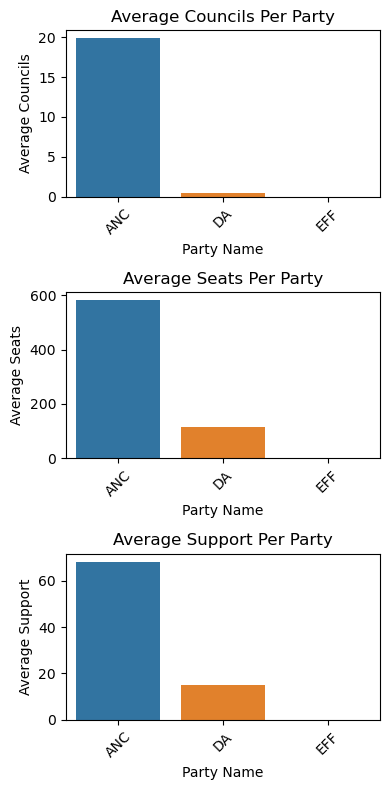

In [132]:
fig, axis = plt.subplots(3, 1, figsize=(4, 8))
party_stats_index = party_stats.reset_index()
sns.barplot(x=party_stats_index["Party Name"], y=party_stats_index["Councils"]["mean"], ax=axis[0])
axis[0].set_title("Average Councils Per Party")
axis[0].set_ylabel("Average Councils")
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index["Party Name"], y=party_stats_index["Seats"]["mean"], ax=axis[1])
axis[1].set_title("Average Seats Per Party")
axis[1].set_ylabel("Average Seats")
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index["Party Name"], y=party_stats_index["Support (%)"]["mean"], ax=axis[2])
axis[2].set_title("Average Support Per Party")
axis[2].set_ylabel("Average Support")
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Distribution of Seats, Councils and Support for each party

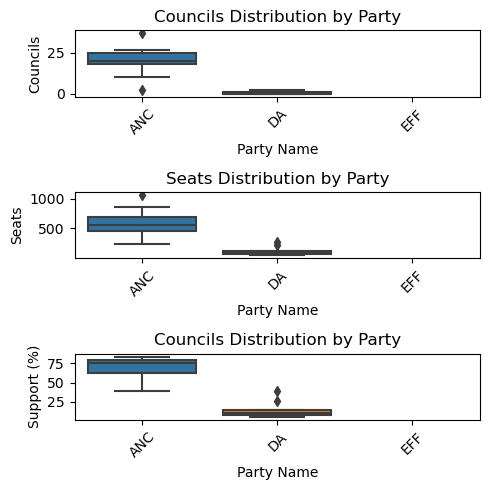

In [142]:
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(x = "Party Name", y = "Councils", data=dataset2006, ax=axes[0])
axes[0].set_title("Councils Distribution by Party")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Seats", data=dataset2006, ax=axes[1])
axes[1].set_title("Seats Distribution by Party")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Support (%)", data=dataset2006, ax=axes[2])
axes[2].set_title("Councils Distribution by Party")
axes[2].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Correlation Analysis

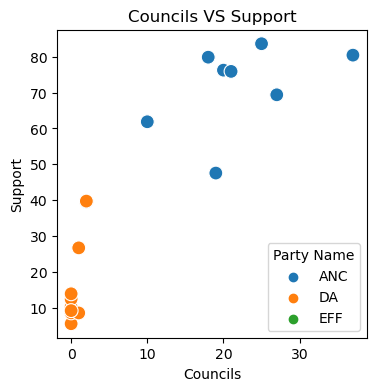

In [149]:
plt.figure(figsize =(4,4))
sns.scatterplot(x="Councils", y="Support (%)", hue="Party Name",data=dataset2006, s=100)
plt.title("Councils VS Support")
plt.xlabel("Councils")
plt.ylabel("Support")
plt.show()

##### Interpretation of the Correlation analysis

### 2011 Descriptive Statistics

In [162]:
dataset2011["Councils"] = pd.to_numeric(dataset2011["Councils"])
dataset2011["Seats"] = pd.to_numeric(dataset2011["Seats"])
dataset2011["Support (%)"] = pd.to_numeric(dataset2011["Support (%)"])

In [164]:
party_stats1 = dataset2011.groupby("Party Name").agg({
    "Councils": ["mean", "median", "std", "min", "max"],
    "Seats": ["mean", "median", "std", "min", "max"],
    "Support (%)": ["mean", "median", "std", "min", "max"]
})

counsil_stats1 = party_stats1["Councils"]
Seats_stats1 = party_stats1["Seats"]
support_stats1 = party_stats1["Support (%)"]

counsil_stats1
Seats_stats1
support_stats1

,mean,median,std,min,max
Party Name,,,,,
ANC,65.363333,71.02,14.371861,33.65,80.59
DA,30.387778,20.02,23.262454,6.52,78.03


#### 2011 Illistration of Local Elections Performance per Party

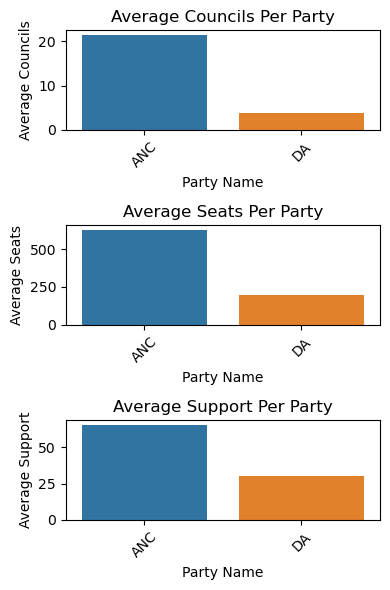

In [188]:
fig, axis = plt.subplots(3, 1, figsize=(4, 6))
party_stats_index1 = party_stats1.reset_index()
sns.barplot(x=party_stats_index1["Party Name"], y=party_stats_index1["Councils"]["mean"], ax=axis[0])
axis[0].set_title("Average Councils Per Party")
axis[0].set_ylabel("Average Councils")
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index1["Party Name"], y=party_stats_index1["Seats"]["mean"], ax=axis[1])
axis[1].set_title("Average Seats Per Party")
axis[1].set_ylabel("Average Seats")
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index1["Party Name"], y=party_stats_index1["Support (%)"]["mean"], ax=axis[2])
axis[2].set_title("Average Support Per Party")
axis[2].set_ylabel("Average Support")
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

#### Distribution

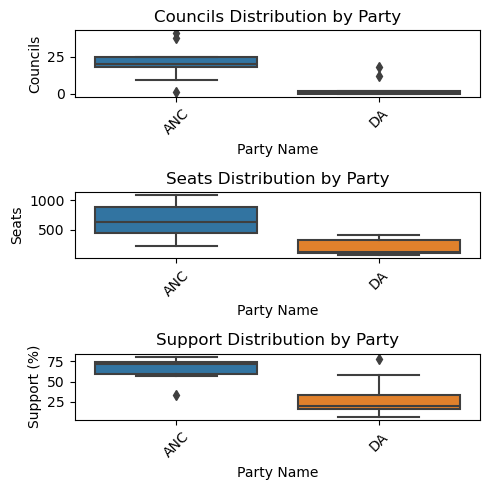

In [182]:
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(x = "Party Name", y = "Councils", data=dataset2011, ax=axes[0])
axes[0].set_title("Councils Distribution by Party")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Seats", data=dataset2011, ax=axes[1])
axes[1].set_title("Seats Distribution by Party")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Support (%)", data=dataset2011, ax=axes[2])
axes[2].set_title("Support Distribution by Party")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

#### Correlation Analysis

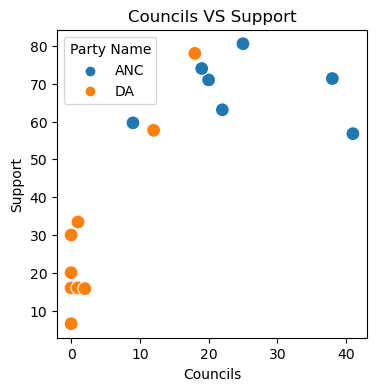

In [191]:
plt.figure(figsize =(4,4))
sns.scatterplot(x="Councils", y="Support (%)", hue="Party Name",data=dataset2011, s=100)
plt.title("Councils VS Support")
plt.xlabel("Councils")
plt.ylabel("Support")
plt.show()

#### Interpretation of Scatterplot

## 2016 Descriptive Statistics

In [200]:
party_stats2 = dataset2016.groupby("Party Name").agg({
    "Councils": ["mean", "median", "std", "min", "max"],
    "Seats": ["mean", "median", "std", "min", "max"],
    "Support (%)": ["mean", "median", "std", "min", "max"]
})

counsil_stats2 = party_stats2["Councils"]
Seats_stats2 = party_stats2["Seats"]
support_stats1 = party_stats2["Support (%)"]

counsil_stats2
Seats_stats2
support_stats2

,mean,median,std,min,max
Party Name,,,,,
ANC,57.054444,59.36,13.673615,26.22,70.74
DA,24.131111,19.70,16.883386,8.06,63.33
EFF,9.117778,9.39,4.837793,2.81,16.73


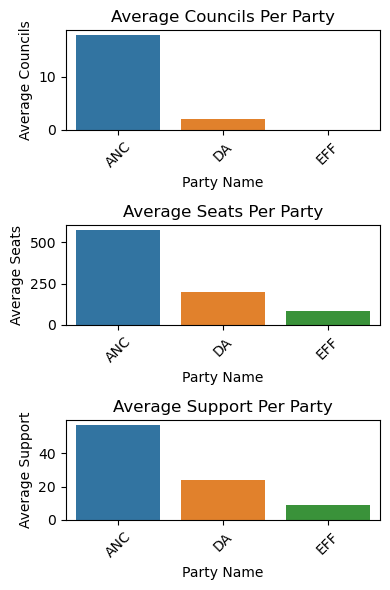

In [202]:
fig, axis = plt.subplots(3, 1, figsize=(4, 6))
party_stats_index2 = party_stats2.reset_index()
sns.barplot(x=party_stats_index2["Party Name"], y=party_stats_index2["Councils"]["mean"], ax=axis[0])
axis[0].set_title("Average Councils Per Party")
axis[0].set_ylabel("Average Councils")
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index2["Party Name"], y=party_stats_index2["Seats"]["mean"], ax=axis[1])
axis[1].set_title("Average Seats Per Party")
axis[1].set_ylabel("Average Seats")
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index2["Party Name"], y=party_stats_index2["Support (%)"]["mean"], ax=axis[2])
axis[2].set_title("Average Support Per Party")
axis[2].set_ylabel("Average Support")
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Distribution

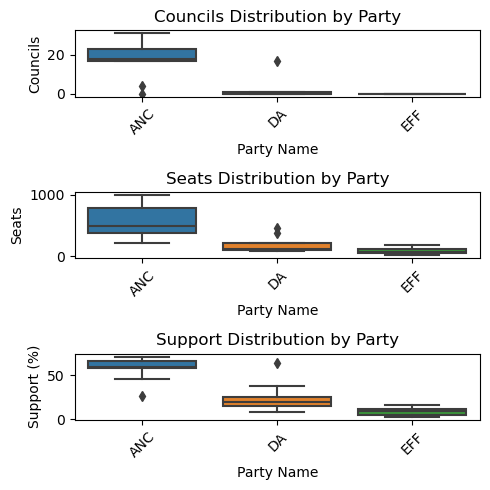

In [205]:
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(x = "Party Name", y = "Councils", data=dataset2016, ax=axes[0])
axes[0].set_title("Councils Distribution by Party")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Seats", data=dataset2016, ax=axes[1])
axes[1].set_title("Seats Distribution by Party")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Support (%)", data=dataset2016, ax=axes[2])
axes[2].set_title("Support Distribution by Party")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Correlation Analysis

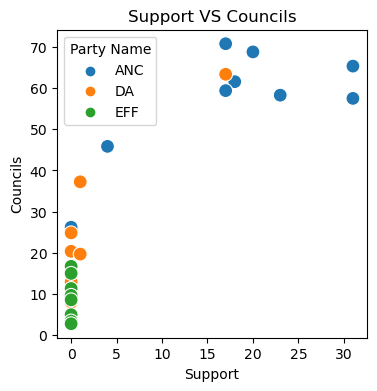

In [208]:
plt.figure(figsize =(4,4))
sns.scatterplot(x="Councils", y="Support (%)", hue="Party Name",data=dataset2016, s=100)
plt.title("Support VS Councils")
plt.xlabel("Support")
plt.ylabel("Councils")
plt.show()

### 2021 Local Elections Descriptive Statistics

In [213]:
party_stats4 = dataset2021.groupby("Party Name").agg({
    "Councils": ["mean", "median", "std", "min", "max"],
    "Seats": ["mean", "median", "std", "min", "max"],
    "Support (%)": ["mean", "median", "std", "min", "max"]
})

counsil_stats4 = party_stats4["Councils"]
Seats_stats4 = party_stats4["Seats"]
support_stats4 = party_stats4["Support (%)"]

counsil_stats4
Seats_stats4
support_stats4

,mean,median,std,min,max
Party Name,,,,,
ANC,50.932222,55.43,15.610447,20.38,68.27
DA,19.152222,13.92,14.614826,5.45,54.26
EFF,11.194444,11.89,5.532985,3.24,18.95


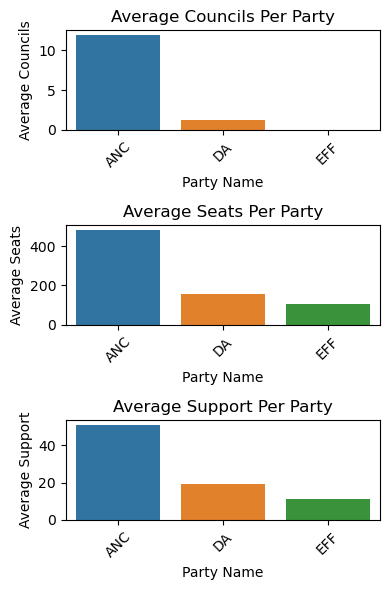

In [216]:
fig, axis = plt.subplots(3, 1, figsize=(4, 6))
party_stats_index4 = party_stats4.reset_index()
sns.barplot(x=party_stats_index4["Party Name"], y=party_stats_index4["Councils"]["mean"], ax=axis[0])
axis[0].set_title("Average Councils Per Party")
axis[0].set_ylabel("Average Councils")
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index4["Party Name"], y=party_stats_index4["Seats"]["mean"], ax=axis[1])
axis[1].set_title("Average Seats Per Party")
axis[1].set_ylabel("Average Seats")
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45)

sns.barplot(x=party_stats_index4["Party Name"], y=party_stats_index4["Support (%)"]["mean"], ax=axis[2])
axis[2].set_title("Average Support Per Party")
axis[2].set_ylabel("Average Support")
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Distribution 

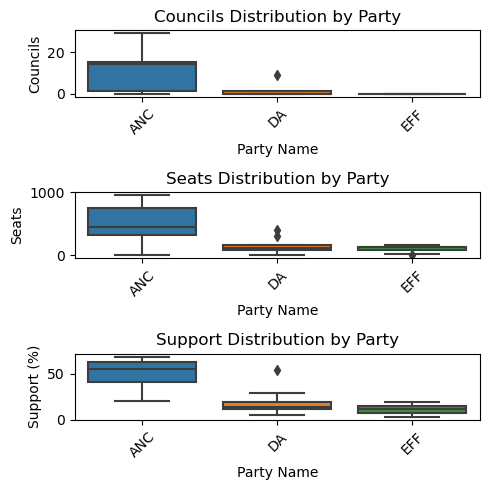

In [219]:
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(x = "Party Name", y = "Councils", data=dataset2021, ax=axes[0])
axes[0].set_title("Councils Distribution by Party")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Seats", data=dataset2021, ax=axes[1])
axes[1].set_title("Seats Distribution by Party")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x = "Party Name", y = "Support (%)", data=dataset2021, ax=axes[2])
axes[2].set_title("Support Distribution by Party")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Correlation Analysis

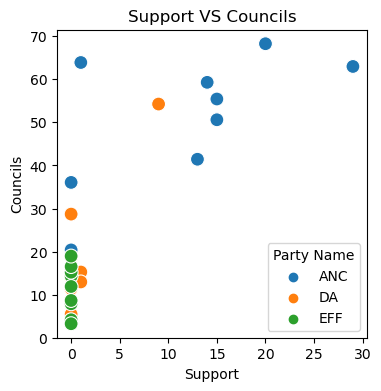

In [222]:
plt.figure(figsize =(4,4))
sns.scatterplot(x="Councils", y="Support (%)", hue="Party Name",data=dataset2021, s=100)
plt.title("Support VS Councils")
plt.xlabel("Support")
plt.ylabel("Councils")
plt.show()

# The Show Stopper MKP (uMkhonto Wesiwe Party)

The Party is only last than a year old but is worthy of being included in the analysis going forward. This is because the last National Elections it has surprised voters by securing 3rd place without any previous track record. The data that will be used for predictions wont be local election results for MKP since it was not around. We will use the National results of MKP as an indicator

In [236]:
dataset2024 = pd.read_excel('elections mk 2024.xlsx')
dataset2024

,Year,Party Name,Province,votes,Seats,Support (%)
0,2024,MK,Limpopo,14364,0,1.00
1,2024,MK,Gauteng,427758,0,10.65
2,2024,MK,Mpumalanga,199000,0,17.24
3,2024,MK,Free State,18785,0,2.26
4,2024,MK,North West,19661,0,2.20
5,2024,MK,Eastern Cape,29433,0,1.63
6,2024,MK,Northern Cape,3729,0,0.94
7,2024,MK,KZN,1615345,0,45.93
8,2024,MK,Western Cape,15766,0,0.79


## Sentimental Analysis

Sentiment Analysis is also known as Opinion Mining. A natural language processing (NLP) technique used to determine the emotional tone behind a body of text. It involves classifying text into different sentiments, like positive, negative, neutral, or other more specific emotions</br>

Sentiment analysis aims to understand people's opinions, emotions, and attitudes expressed in written text. It is widely used in various applications such as customer feedback analysis, social media monitoring, market research, and brand management.

#### Retrive Abstracts of Articles of each Part. We aim to see if senitiments of each party may lead to growth or decline of a party

In [275]:
data = {
    'Party': ['ANC', 'ANC', 'ANC', 'DA', 'DA', 'DA', 'EFF', 'EFF', 'EFF', 'MKP', 'MKP', 'MKP'],
    'Province': ['Limpopo', 'Free State', 'Mpumalanga', 'Western Cape', 'Gauteng', 'Free State', 'Northern Cape', 'Limpopo', 'Mpumalanga', 'KZN', 'Mpumalanga', 'Gauteng'],
    'Article': [
        "The ANC's support in Gauteng dropped from 50 percent in 2019 to 34 percent in the 2024 general elections The party's national and regional leadership reflected on the difficult election with ANC provincial secretary TK Nciza stating that branches were open about issues like poor service delivery contributing to the decline ANC Secretary General Fikile Mbalula highlighted poor government performance electricity cuts illegal immigration and petty crime as key factors behind the loss of voter confidence The ANC is now focusing on strategies to regain support following the electoral setback",
        "The ANC is distancing itself from the EFF in Gauteng and moving towards the DA. The EFF demanded that Nkululeko Dunga be reinstated as finance MMC in Ekurhuleni but the ANC appointed Jongisizwe Nhlabathi instead. After Dunga's removal in June tensions grew between the ANC and EFF in Ekurhuleni. This week EFF members rejected a loan in Johannesburg's council as retaliation for Dunga's removal. It is likely EFF MMCs in Johannesburg will be removed as ANC and DA strengthen their relationship. The ANC's Johannesburg region supports this move and also seeks to replace the mayor with Dada Morero. In eThekwini the ANC's Cyril Xaba was elected mayor with DA support pushing the EFF further away from influence. This alliance between ANC and DA is expected to extend to other KZN municipalities.",
        "Despite the challenges, the ANC remains committed to improving the livelihoods of South Africans. President Ramaphosa has outlined a comprehensive economic recovery plan, focusing on job creation and infrastructure development, signaling hope for a more prosperous future.",
        "The DA's performance in the 2024 elections saw a slight increase in support in urban areas, as voters turned to the party for its promise of cleaner governance and better service delivery. The party’s leadership believes this is a sign of growing confidence in its ability to govern.",
        "Critics argue that the DA's policies disproportionately favor the affluent, particularly in the Western Cape, where inequality remains a significant issue. Many believe the party needs to do more to address the needs of poorer communities",
        "The DA continues to push for greater decentralization of power from the national government, emphasizing the need for provinces to have more control over key services such as policing and education. This stance has resonated with many South Africans frustrated by the slow pace of national reforms.",
        "The EFF's fiery rhetoric and confrontational stance on land expropriation without compensation have earned the party a strong following among disenfranchised youth. Julius Malema continues to push for radical economic transformation, calling for the nationalization of key industries.",
        "Many analysts believe the EFF's aggressive tactics in parliament have undermined its credibility as a serious political force. While the party's support base remains loyal, its approach has alienated potential voters who are looking for more practical solutions to economic challenges.",
        "The EFF has been praised for its strong anti-corruption stance and efforts to hold the ANC government accountable. Malema's calls for transparency and justice have resonated with voters tired of the ruling party’s scandals.",
        "The MKP continues to advocate for the recognition of the Khoisan people's rights and the protection of minority communities in South Africa. The party has called for more representation in government to address issues affecting indigenous groups.",
        "Despite its small size, the MKP has been vocal in pushing for land reform policies that take into account the historical injustices faced by indigenous communities. The party's leadership believes that a more inclusive approach to land redistribution is needed.",
        "The MKP has faced criticism for failing to gain widespread support in national elections, with some questioning its ability to appeal to a broader base. However, the party remains focused on its mission to fight for the rights of marginalized groups.."
    ]
}

df = pd.DataFrame(data)
df.head(12)

,Party,Province,Article
0,ANC,Limpopo,The ANC's support in Gauteng dropped from 50 p...
1,ANC,Free State,The ANC is distancing itself from the EFF in G...
2,ANC,Mpumalanga,"Despite the challenges, the ANC remains commit..."
3,DA,Western Cape,The DA's performance in the 2024 elections saw...
4,DA,Gauteng,Critics argue that the DA's policies dispropor...
5,DA,Free State,The DA continues to push for greater decentral...
6,EFF,Northern Cape,The EFF's fiery rhetoric and confrontational s...
7,EFF,Limpopo,Many analysts believe the EFF's aggressive tac...
8,EFF,Mpumalanga,The EFF has been praised for its strong anti-c...
9,MKP,KZN,The MKP continues to advocate for the recognit...


#### Cleaning our Qualitative Data

In [289]:
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

df['Cleaned_Article'] = df['Article'].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Party,Province,Article,Cleaned_Article
0,ANC,Limpopo,The ANC's support in Gauteng dropped from 50 p...,anc support gauteng dropped percent percent ge...
1,ANC,Free State,The ANC is distancing itself from the EFF in G...,anc distancing eff gauteng moving towards da e...
2,ANC,Mpumalanga,"Despite the challenges, the ANC remains commit...",despite challenges anc remains committed impro...
3,DA,Western Cape,The DA's performance in the 2024 elections saw...,da performance elections saw slight increase s...
4,DA,Gauteng,Critics argue that the DA's policies dispropor...,critics argue da policies disproportionately f...


### Sentiment Analysis

In [306]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Cleaned_Article'].apply(get_sentiment)
df[['Party', 'Province', 'Sentiment']]

,Party,Province,Sentiment
0,ANC,Limpopo,Negative
1,ANC,Free State,Negative
2,ANC,Mpumalanga,Positive
3,DA,Western Cape,Positive
4,DA,Gauteng,Positive
5,DA,Free State,Neutral
6,EFF,Northern Cape,Positive
7,EFF,Limpopo,Negative
8,EFF,Mpumalanga,Positive
9,MKP,KZN,Neutral


### Visualizations of Sentiments

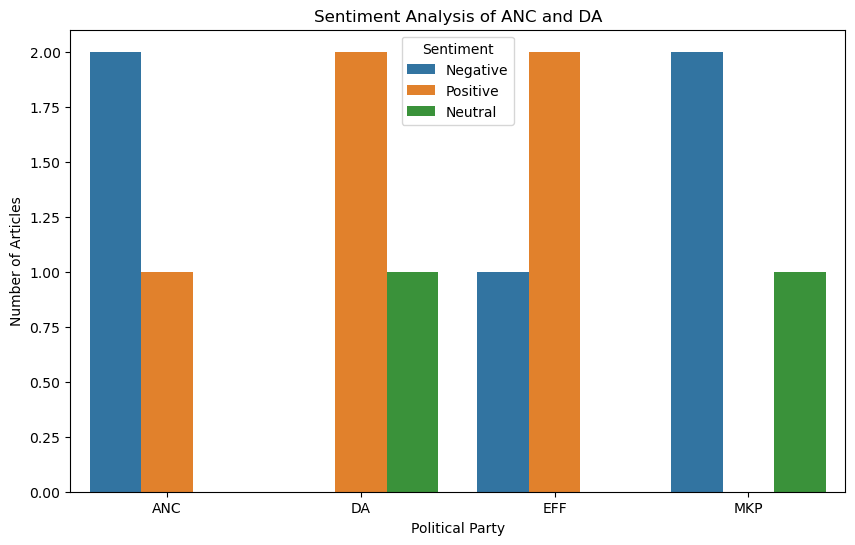

In [309]:
sentiment_count = df.groupby(['Party', 'Sentiment']).size().reset_index(name='Counts')

# Barplot: Sentiment count for each party
plt.figure(figsize=(10,6))
sns.barplot(x='Party', y='Counts', hue='Sentiment', data=sentiment_count)
plt.title('Sentiment Analysis of ANC and DA')
plt.ylabel('Number of Articles')
plt.xlabel('Political Party')
plt.show()

### Pie Charts of Sentiments

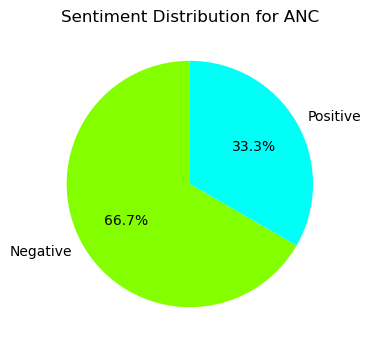

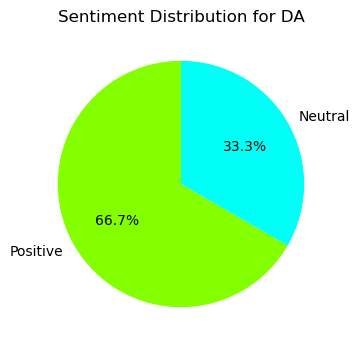

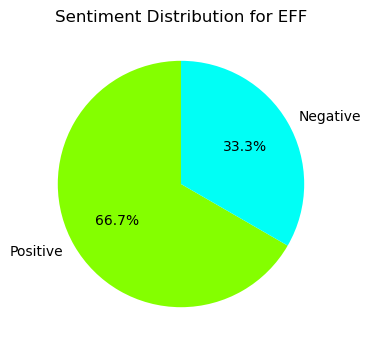

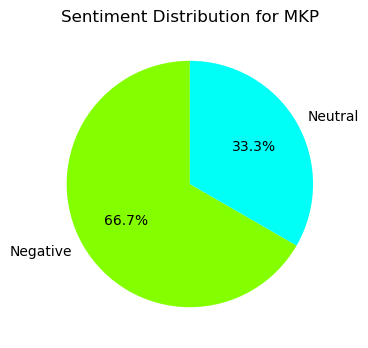

In [314]:
party_groups = df.groupby('Party')
for party, group in party_groups:
    sentiment_distribution = group['Sentiment'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("hsv", 3))
    plt.title(f'Sentiment Distribution for {party}')
    plt.show()

## Discussion of Sentiments

**ANC (African National Congress)**: The ANC's sentiments are predominantly negative in Limpopo and Free State, indicating dissatisfaction or criticism in these areas. However, there is a positive sentiment in Mpumalanga, suggesting some favorable views or achievements in that province. This mixed sentiment could reflect broader challenges the ANC faces, including issues related to governance and service delivery.

**DA (Democratic Alliance)**: The DA's sentiment is generally positive in the Western Cape and Gauteng, with a neutral stance in the Free State. This suggests that the DA is perceived positively in areas where it has strong support, particularly in urban centers. The positive sentiment could be attributed to the party's focus on effective governance and service delivery. The neutral sentiment in the Free State might indicate a more ambivalent or less pronounced opinion among voters.

**EFF (Economic Freedom Fighters)**: The EFF shows a mix of positive and negative sentiments. Positive sentiment is noted in Northern Cape and Mpumalanga, indicating support or approval in these regions. However, there is a negative sentiment in Limpopo, which might reflect dissatisfaction with the party's performance or policies. The mixed sentiment could be linked to the EFF's radical approach and its controversial stances on various issues.

**MKP (Mkhonto Wesiwe Party)**: The MKP's sentiments are predominantly negative in Mpumalanga and Gauteng, with a neutral sentiment in KZN. The negative sentiment could be a result of limited visibility or impact in these areas, suggesting challenges in gaining broader support or addressing key issues effectively. The neutral sentiment in KZN may reflect a more balanced or indifferent view towards the party's activities.

# Machine Learning Models for Predictions

#### Combined Dataset for all past Local Election Results

In [330]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.Collecting prophet
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 1.3 MB/s eta 0:00:11
   ---------------------------------------- 0.0/13.3 MB 653.6 kB/s eta 0:00:21
   ---------------------------------------- 0.1/13.3 MB 762.6 kB/s eta 0:00:18
   ---------------------------------------- 0.1/13.3 MB 726.2 kB/s eta 0:00:19
   ---------------------------------------- 0.2/13.3 MB 706.2 kB/s eta 0:00:19
   ---------------------------------------- 0.2/13.3 MB 656.4 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 654.4 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 654.4 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 654.4 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 654.4 kB/s eta 0:00:21
    --------------------------------------- 0.2/13.3 MB 38

In [326]:
combined = pd.read_excel('local elections.xlsx')
combined.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2006,ANC,Limpopo,25,856,83.59
1,2006,ANC,Gauteng,10,532,61.85
2,2006,ANC,Mpumalanga,18,578,79.84
3,2006,ANC,Free State,20,462,76.23
4,2006,ANC,North West,21,554,75.88


In [425]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 2.6 MB/s eta 0:00:49
   ---------------------------------------- 0.3/124.9 MB 2.3 MB/s eta 0:00:54
   ---------------------------------------- 0.5/124.9 MB 2.1 MB/s eta 0:01:01
   ---------------------------------------- 0.7/124.9 MB 1.9 MB/s eta 0:01:07
   ---------------------------------------- 0.7/124.9 MB 1.8 MB/s eta 0:01:11
   ---------------------------------------- 0.8/124.9 MB 1.8 MB/s eta 0:01:10
   ---------------------------------------- 0.8/124.9 MB 1.8 MB/s eta 0:01:10
   ---------------------------------------- 0.9/124.9 MB 1.7 MB/s eta 0:01:13
   ---------------------------------------- 1.0/124.9 MB 1.8 MB/s eta 0:01:11
   ---------------------------------------- 1.2/124.9 MB 1.7 MB/s eta 0:01:13
   ---------------------------------------- 1.3/124.9 MB 1.6 MB/s eta 0:01:18
   ---------------------------------------- 1.3/124.9 MB 1.6 MB/s eta 0

In [573]:
combined1 = pd.read_excel('ANC.xlsx')
combined1.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2011,ANC,Limpopo,25,882,80.59
1,2011,ANC,Gauteng,9,622,59.66
2,2011,ANC,Mpumalanga,18,625,78.03
3,2011,ANC,Free State,20,448,71.02
4,2011,ANC,North West,19,571,74.03


# Linear Regression Analysis 

## The predictions will be limited to the Gauteng Province, since a lot of economic activities happen here (These predictions serve a way make sure the people of Gauteng make informed decisions)

### ANC 2026 Prediction In Gauteng

    Year Party Name Province  Councils  Seats  Support (%)
1   2011        ANC  Gauteng         9    622        59.66
10  2016        ANC  Gauteng         4    499        45.84
19  2021        ANC  Gauteng         0    399        36.06


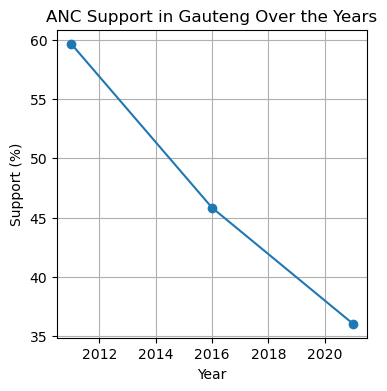

Data prepared for machine learning models.


In [577]:
gauteng_df = combined1[combined1['Province'] == 'Gauteng']
print(gauteng_df)

plt.figure(figsize=(4, 4))
plt.plot(gauteng_df['Year'], gauteng_df['Support (%)'], marker='o')
plt.title('ANC Support in Gauteng Over the Years')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.grid(True)
plt.show()

# Prepare data for ML models
X = gauteng_df[['Year']]
y = gauteng_df['Support (%)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared for machine learning models.")  

    Year Party Name Province  Councils  Seats  Support (%)
1   2011        ANC  Gauteng         9    622        59.66
10  2016        ANC  Gauteng         4    499        45.84
19  2021        ANC  Gauteng         0    399        36.06


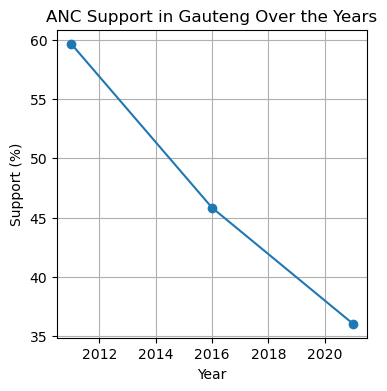

Data prepared for machine learning models.


In [488]:
gauteng_df = combined1[combined1['Province'] == 'Gauteng']
print(gauteng_df)

plt.figure(figsize=(4, 4))
plt.plot(gauteng_df['Year'], gauteng_df['Support (%)'], marker='o')
plt.title('ANC Support in Gauteng Over the Years')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.grid(True)
plt.show()

# Prepare data for ML models
X = gauteng_df[['Year']]
y = gauteng_df['Support (%)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared for machine learning models.")  

#### Next, I'll apply Linear Regression, Random Forest Regression, and XGBoost Regression to predict the 2026 support percentage.

In [579]:

linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

linear_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)

X_2026 = np.array([[2026]])
linear_pred = linear_reg.predict(X_2026)
rf_pred = random_forest.predict(X_2026)
xgb_pred = xgb_reg.predict(X_2026)

# Print predictions
print("Linear Regression Prediction for 2026: ", linear_pred[0])
print("Random Forest Prediction for 2026: ", rf_pred[0])
print("XGBoost Prediction for 2026: ", xgb_pred[0])

# Evaluate models on test data
linear_test_pred = linear_reg.predict(X_test)
rf_test_pred = random_forest.predict(X_test)
xgb_test_pred = xgb_reg.predict(X_test)

print("\
Model Evaluation:")
print("Linear Regression RMSE: ", np.sqrt(mean_squared_error(y_test, linear_test_pred)))
print("Random Forest RMSE: ", np.sqrt(mean_squared_error(y_test, rf_test_pred)))
print("XGBoost RMSE: ", np.sqrt(mean_squared_error(y_test, xgb_test_pred)))

print("Linear Regression R2: ", r2_score(y_test, linear_test_pred))
print("Random Forest R2: ", r2_score(y_test, rf_test_pred))
print("XGBoost R2: ", r2_score(y_test, xgb_test_pred))

print("Predictions and evaluations completed.")

Linear Regression Prediction for 2026:  26.279999999999745
Random Forest Prediction for 2026:  38.60279999999998
XGBoost Prediction for 2026:  36.060886
Model Evaluation:
Linear Regression RMSE:  4.0400000000005605
Random Forest RMSE:  15.971599999999953
XGBoost RMSE:  13.820884857177731
Linear Regression R2:  nan
Random Forest R2:  nan
XGBoost R2:  nan
Predictions and evaluations completed.


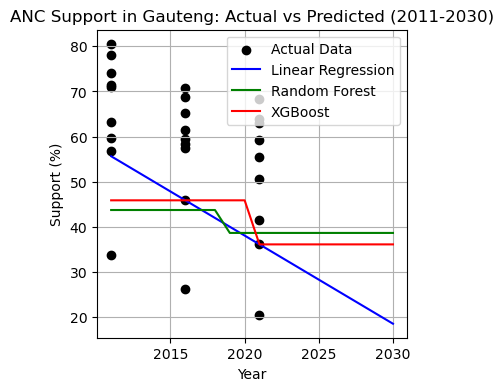

In [581]:
years = np.arange(2011, 2031, 1).reshape(-1, 1)

# Generate predictions for each model
linear_pred = linear_reg.predict(years)
rf_pred = random_forest.predict(years)
xgb_pred = xgb_reg.predict(years)

# Plot the results
plt.figure(figsize=(4, 4))
plt.scatter(combined1['Year'], combined1['Support (%)'], color='black', label='Actual Data')
plt.plot(years, linear_pred, label='Linear Regression', color='blue')
plt.plot(years, rf_pred, label='Random Forest', color='green')
plt.plot(years, xgb_pred, label='XGBoost', color='red')

plt.title('ANC Support in Gauteng: Actual vs Predicted (2011-2030)')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.legend()
plt.grid(True)

warnings.filterwarnings('ignore')

### DA 2026 Prediction In Gauteng

In [557]:
combined2 = pd.read_excel('DA1.xlsx')
combined2.head(5)

,Year,Party Name,Province,Councils,Seats,Support
0,2006,DA,Gauteng,1,219,26.72
1,2006,DA,Mpumalanga,0,83,10.33
2,2006,DA,Free State,0,74,12.46
3,2006,DA,North West,0,68,8.62
4,2006,DA,Eastern Cape,1,93,8.59


In [527]:

gauteng_data = combined2[combined2['Province'] == 'Gauteng']
print("\
Gauteng Data:")
print(gauteng_data)

Gauteng Data:
    Year Party Name Province  Councils  Seats  Support
0   2006         DA  Gauteng         1    219    26.72
9   2011         DA  Gauteng         1    330    33.43
17  2016         DA  Gauteng         1    377    37.23
26  2021         DA  Gauteng         0    303    28.70


In [561]:
X = gauteng_data[['Year']]
y = gauteng_data['Supports']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
linear_regression = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Train the models
linear_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

y_pred_lr = linear_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_gb = gradient_boosting.predict(X_test)

# Evaluate the models
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)

r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
r2_gb = r2_score(y_test, y_pred_gb)

# Print the evaluation metrics
print("Linear Regression MSE:", mse_lr)
print("Random Forest MSE:", mse_rf)
print("Gradient Boosting MSE:", mse_gb)

print("Linear Regression R^2:", r2_lr)
print("Random Forest R^2:", r2_rf)
print("Gradient Boosting R^2:", r2_gb)


Linear Regression MSE: 0.2809000000000012
Random Forest MSE: 0.2809000000000012
Gradient Boosting MSE: 0.2809000000000012
Linear Regression R^2: nan
Random Forest R^2: nan
Gradient Boosting R^2: nan


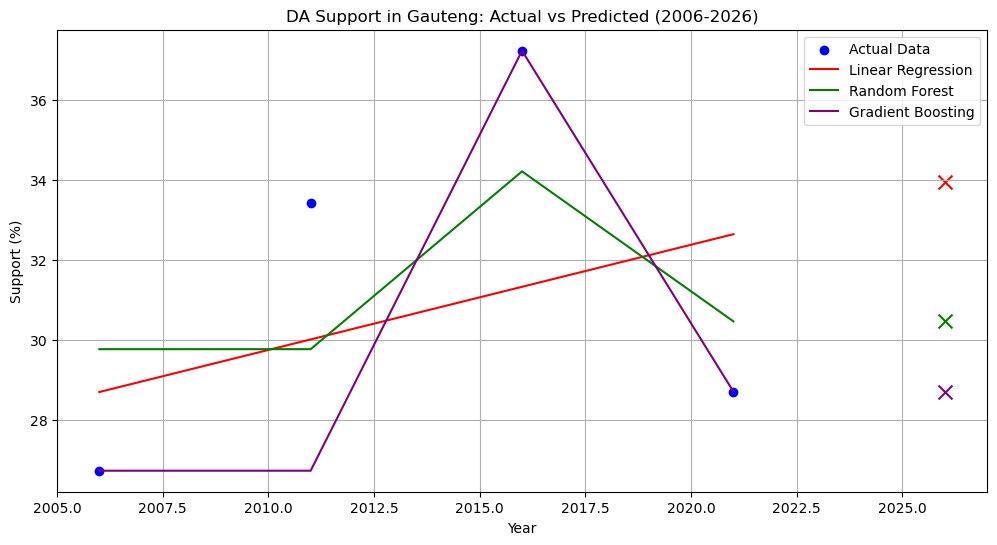

2026 Predictions:
Linear Regression: 33.95%
Random Forest: 30.46%
Gradient Boosting: 28.70%


In [549]:
gauteng_data = combined2[combined2['Province'] == 'Gauteng']
years = gauteng_data['Year'].values
support = gauteng_data['Support'].values

# Generate predictions for 2026
future_year = np.array([[2026]])
lr_pred = linear_regression.predict(future_year)
rf_pred = random_forest.predict(future_year)
gb_pred = gradient_boosting.predict(future_year)

# Plot the data and predictions
plt.figure(figsize=(12, 6))
plt.scatter(years, support, color='blue', label='Actual Data')
plt.plot(years, linear_regression.predict(years.reshape(-1, 1)), color='red', label='Linear Regression')
plt.plot(years, random_forest.predict(years.reshape(-1, 1)), color='green', label='Random Forest')
plt.plot(years, gradient_boosting.predict(years.reshape(-1, 1)), color='purple', label='Gradient Boosting')

# Add 2026 predictions
plt.scatter(2026, lr_pred, color='red', marker='x', s=100)
plt.scatter(2026, rf_pred, color='green', marker='x', s=100)
plt.scatter(2026, gb_pred, color='purple', marker='x', s=100)

plt.title('DA Support in Gauteng: Actual vs Predicted (2006-2026)')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.legend()
plt.grid(True)
plt.show()

print("2026 Predictions:")
print(f"Linear Regression: {lr_pred[0]:.2f}%")
print(f"Random Forest: {rf_pred[0]:.2f}%")
print(f"Gradient Boosting: {gb_pred[0]:.2f}%")

warnings.filterwarnings('ignore')

### EFF 2026 Prediction In Gauteng

In [539]:
eff = pd.read_excel('EFF.xlsx')
eff.head(5)

,Year,Party Name,Province,Councils,Seats,Supports
0,2016,EFF,Limpopo,0,190,16.73
1,2016,EFF,Gauteng,0,122,11.36
2,2016,EFF,Mpumalanga,0,79,9.39
3,2016,EFF,Free State,0,63,9.69
4,2016,EFF,North West,0,119,15.02


In [563]:
gauteng_df = eff[eff['Province'] == 'Gauteng']
print(gauteng_df)

    Year Party Name Province  Councils  Seats  Supports
1   2016        EFF  Gauteng         0    122     11.36
10  2021        EFF  Gauteng         0    134     11.89


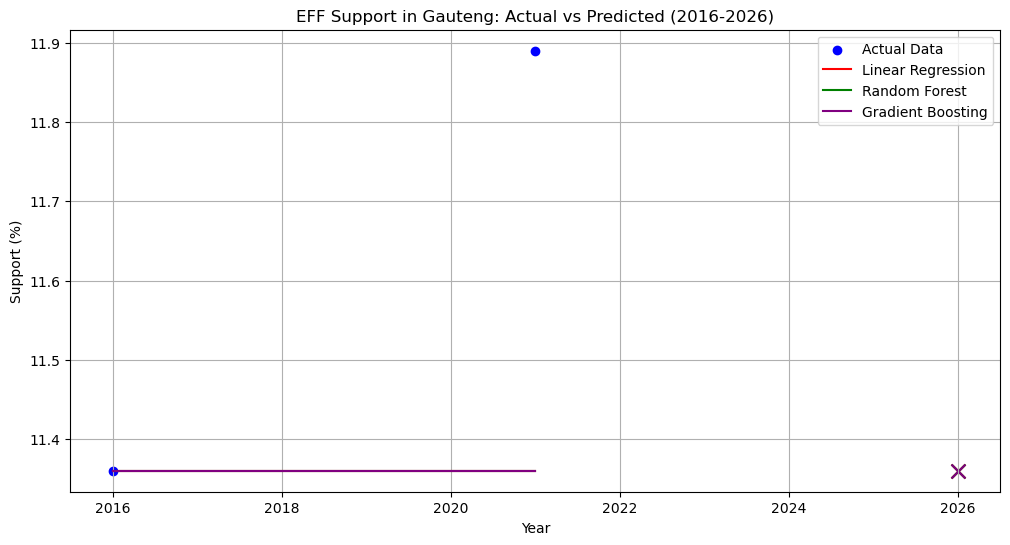

2026 Predictions:
Linear Regression: 11.36%
Random Forest: 11.36%
Gradient Boosting: 11.36%


In [567]:
gauteng_data = eff[eff['Province'] == 'Gauteng']
years = gauteng_data['Year'].values
support = gauteng_data['Supports'].values

future_year = np.array([[2026]])
lr_pred = linear_regression.predict(future_year)
rf_pred = random_forest.predict(future_year)
gb_pred = gradient_boosting.predict(future_year)

plt.figure(figsize=(12, 6))
plt.scatter(years, support, color='blue', label='Actual Data')
plt.plot(years, linear_regression.predict(years.reshape(-1, 1)), color='red', label='Linear Regression')
plt.plot(years, random_forest.predict(years.reshape(-1, 1)), color='green', label='Random Forest')
plt.plot(years, gradient_boosting.predict(years.reshape(-1, 1)), color='purple', label='Gradient Boosting')

plt.scatter(2026, lr_pred, color='red', marker='x', s=100)
plt.scatter(2026, rf_pred, color='green', marker='x', s=100)
plt.scatter(2026, gb_pred, color='purple', marker='x', s=100)

plt.title('EFF Support in Gauteng: Actual vs Predicted (2016-2026)')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.legend()
plt.grid(True)
plt.show()

print("2026 Predictions:")
print(f"Linear Regression: {lr_pred[0]:.2f}%")
print(f"Random Forest: {rf_pred[0]:.2f}%")
print(f"Gradient Boosting: {gb_pred[0]:.2f}%")

warnings.filterwarnings('ignore')

### MKP 2026 Prediction Wont be accurate as there is very limited data. And models cant be trained

## Facebook Prophet 

In [585]:
combined = pd.read_excel('local elections.xlsx')
combined.head(5)

,Year,Party Name,Province,Councils,Seats,Support (%)
0,2006,ANC,Limpopo,25,856,83.59
1,2006,ANC,Gauteng,10,532,61.85
2,2006,ANC,Mpumalanga,18,578,79.84
3,2006,ANC,Free State,20,462,76.23
4,2006,ANC,North West,21,554,75.88


In [603]:
# Filter for Gauteng
gauteng_df = combined[combined['Province'] == 'Gauteng']

prophet_data = gauteng_df.pivot(index='Year', columns='Party Name', values='Support (%)')
prophet_data.reset_index(inplace=True)
prophet_data['Year'] = pd.to_datetime(prophet_data['Year'], format='%Y')

print(prophet_data.head())

parties = prophet_data.columns[1:] 
forecasts = {}

for party in parties:
    party_data = prophet_data[['Year', party]].rename(columns={'Year': 'ds', party: 'y'})
    party_data = party_data.dropna()
    
    if len(party_data) > 1:
        model = Prophet()
        model.fit(party_data)
        
        future = model.make_future_dataframe(periods=10, freq='Y')
        forecast = model.predict(future)
        forecasts[party] = forecast

plt.figure(figsize=(12, 6))
for party, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=party)
    plt.scatter(prophet_data['Year'], prophet_data[party], label=f'{party} (actual)')

plt.title('Facebook Prophet Prediction for 2026 Local Elections in Gauteng')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.legend()
plt.grid(True)
plt.savefig('gauteng_election_forecast.png')
plt.close()

print("\
2026 Predictions:")
for party, forecast in forecasts.items():
    prediction_2026 = forecast[forecast['ds'].dt.year == 2026]['yhat'].values[0]
    print(f"{party}: {prediction_2026:.2f}%")

print("\
Forecast image saved as 'gauteng_election_forecast.png'")

Party Name       Year    ANC     DA    EFF     MK
0          2006-01-01  61.85  26.72    NaN    NaN
1          2011-01-01  59.66  33.43    NaN    NaN
2          2016-01-01  45.84  37.23  11.36    NaN
3          2021-01-01  36.06  28.70  11.89    NaN
4          2024-01-01    NaN    NaN    NaN  10.65


10:53:43 - cmdstanpy - INFO - Chain [1] start processing
10:53:43 - cmdstanpy - INFO - Chain [1] done processing
10:53:44 - cmdstanpy - INFO - Chain [1] start processing
10:53:44 - cmdstanpy - INFO - Chain [1] done processing
10:53:45 - cmdstanpy - INFO - Chain [1] start processing
10:53:58 - cmdstanpy - INFO - Chain [1] done processing


2026 Predictions:
ANC: 26.46%
DA: 40.58%
EFF: -14.42%
Forecast image saved as 'gauteng_election_forecast.png'


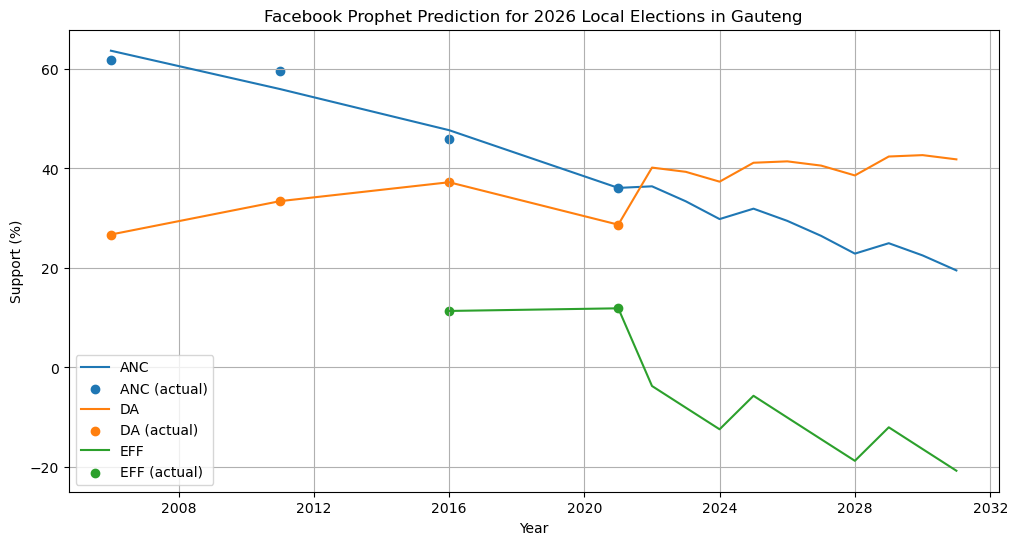

In [605]:
plt.figure(figsize=(12, 6))
for party, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=party)
    plt.scatter(prophet_data['Year'], prophet_data[party], label=f'{party} (actual)')

plt.title('Facebook Prophet Prediction for 2026 Local Elections in Gauteng')
plt.xlabel('Year')
plt.ylabel('Support (%)')
plt.legend()
plt.grid(True)
plt.show()

The forecast for the 2026 local elections in Gauteng shows projected support percentages for the ANC, DA, and EFF parties based on historical data. The plot visually represents these predictions, allowing for a clear comparison of trends over time.

# Reflection

**Understanding the Data and the Importance of Forecasting Local Elections**
Our dataset comprises historical data of election results, specifically focused on a column indicating the Year of each election and another column representing the Votes or percentage support for a particular political party or candidate. This data is crucial as it provides a quantitative basis to analyze trends in voter behavior and political support over time. Forecasting future election results, such as the upcoming 2026 South African local elections, is important for several reasons. It helps political parties strategize more effectively, enables government bodies and analysts to prepare for potential changes in political power, and provides insight into public opinion trends. Accurate forecasts can also help in resource allocation, policy planning, and enhancing democratic processes by understanding the electorate's evolving preferences.</br>

**Descriptive Statistics and Initial Analysis**
Before proceeding with any predictive modeling, it is essential to perform a descriptive statistical analysis of the dataset. Descriptive statistics provide a comprehensive overview of the data's central tendencies, variability, and overall distribution. By examining key metrics such as the mean, median, standard deviation, and range of votes across different years, we gain a clearer understanding of historical voting patterns and the volatility of political support. Additionally, visual tools such as histograms, box plots, and scatter plots help in identifying any outliers or anomalies in the data that could influence the forecasting model. This initial exploration of the data ensures that we have a robust foundation for making predictions, allowing us to detect and address any potential biases or inconsistencies.</br>

**Predictions Using Linear Regression**
The predictive analysis involved applying a Linear Regression model to forecast the 2026 local elections based on historical voting data. Linear Regression is a simple yet effective model for predicting future values when there is a linear relationship between the dependent and independent variables. By using the Year as the independent variable and Votes as the dependent variable, we were able to fit a regression line that approximates the trend of voting behavior over the past years. The model's predictions for the 2026 elections were then generated, providing an estimated value of future votes. While this approach offers a basic predictive insight, it is important to note that the accuracy of such predictions depends heavily on the linearity of historical data trends and external factors like political dynamics, socio-economic changes, and public sentiment shifts that the model does not account for. Thus, while linear regression provides a valuable forecast, it should be interpreted cautiously and complemented with other predictive models and qualitative analysis.

Note: parts of texts was generated by AI based on the analysis for a comprehensive understanding